# Degradation experiments with reference performance tests

When running degradation experiments in the lab, it is important to use reference performance tests (RPTs) to measure capacity and other key metrics, otherwise the experimental contitions will interfere with the measurement! In PyBaMM, you can run simulations with RPTs using the `Experiment` class.

In [1]:
%pip install pybamm[plot,cite] -q  # install PyBaMM if it is not installed

import pybamm
import matplotlib.pyplot as plt
import os

os.chdir(pybamm.__path__[0]+'/..')

Note: you may need to restart the kernel to use updated packages.


Load a simple degradation model

In [2]:
model = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited"})
parameter_values = pybamm.ParameterValues("Mohtat2020")
parameter_values.update({"SEI kinetic rate constant [m.s-1]": 1e-14})

Define three different experiments using the Experiment class:
* cccv_experiment is a cycle ageing experiment
* charge_experiment charges to full after N ageing cycles
* rpt_experiment is a C/3 discharge in this case, but can also contain a charge, GITT, EIS and other procedures

In [3]:
N = 10
cccv_experiment = pybamm.Experiment([
    ("Charge at 1C until 4.2V", 
     "Hold at 4.2V until C/50",
     "Discharge at 1C until 3V",
     "Rest for 1 hour",
    )
] * N)
charge_experiment = pybamm.Experiment([
    ("Charge at 1C until 4.2V", 
     "Hold at 4.2V until C/50",
    )
])
rpt_experiment = pybamm.Experiment([
    ("Discharge at C/3 until 3V",)
])

Run the ageing, charge and RPT experiments in order by feeding the previous solution into the solve command:

In [4]:
sim = pybamm.Simulation(model, experiment=cccv_experiment, parameter_values=parameter_values)
cccv_sol = sim.solve()
sim = pybamm.Simulation(model, experiment=charge_experiment, parameter_values=parameter_values)
charge_sol = sim.solve(starting_solution=cccv_sol)
sim = pybamm.Simulation(model, experiment=rpt_experiment, parameter_values=parameter_values)
rpt_sol = sim.solve(starting_solution=charge_sol)

Plot detailed current/voltage data for the RPT cycle only:

In [5]:
pybamm.dynamic_plot(rpt_sol.cycles[-1], ["Current [A]", "Voltage [V]"])

interactive(children=(FloatSlider(value=32.16021213978805, description='t', max=34.910964151192324, min=32.160…

PyBaMM's summary variables track important cell-level degradation veriables at the end of each cycle. The charge and RPT cycles are also counted, making a total of 12 cycles:

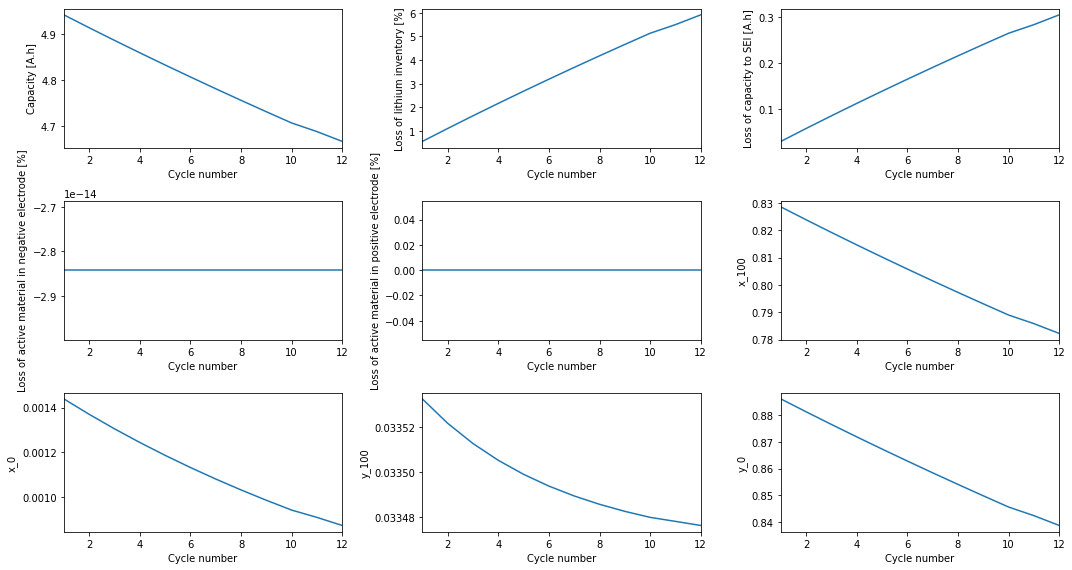

In [6]:
pybamm.plot_summary_variables(rpt_sol);

Repeat the procedure four times:

In [7]:
cccv_sols = []
charge_sols = []
rpt_sols = []
M = 5
for i in range(M):
    if i != 0:  # skip the first set of ageing cycles because it's already been done
        sim = pybamm.Simulation(model, experiment=cccv_experiment, parameter_values=parameter_values)
        cccv_sol = sim.solve(starting_solution=rpt_sol)
        sim = pybamm.Simulation(model, experiment=charge_experiment, parameter_values=parameter_values)
        charge_sol = sim.solve(starting_solution=cccv_sol)
        sim = pybamm.Simulation(model, experiment=rpt_experiment, parameter_values=parameter_values)
        rpt_sol = sim.solve(starting_solution=charge_sol)
    cccv_sols.append(cccv_sol)
    charge_sols.append(charge_sol)
    rpt_sols.append(rpt_sol)

You can plot any RPT cycle. The last one is chosen here.

In [8]:
pybamm.dynamic_plot(rpt_sols[-1].cycles[-1], ["Current [A]", "Voltage [V]"])

interactive(children=(FloatSlider(value=161.47100901868143, description='t', max=163.71508382969813, min=161.4…

One way of demonstrating how useful RPTs are is to plot the discharge capacity for each cycle. It is convenient to use the final `rpt_sol` because it also contains all previous simulations.

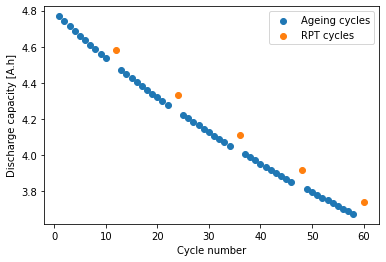

In [9]:
cccv_cycles = []
cccv_capacities = []
rpt_cycles = []
rpt_capacities = []
for i in range (M):
    for j in range(N):
        cccv_cycles.append(i*(N+2)+j+1)
        start_capacity = rpt_sol.cycles[i*(N+2)+j].steps[2]["Discharge capacity [A.h]"].entries[0]
        end_capacity = rpt_sol.cycles[i*(N+2)+j].steps[2]["Discharge capacity [A.h]"].entries[-1]
        cccv_capacities.append(end_capacity-start_capacity)
    rpt_cycles.append((i+1)*(N+2))
    start_capacity = rpt_sol.cycles[(i+1)*(N+2)-1]["Discharge capacity [A.h]"].entries[0]
    end_capacity = rpt_sol.cycles[(i+1)*(N+2)-1]["Discharge capacity [A.h]"].entries[-1]
    rpt_capacities.append(end_capacity-start_capacity)
plt.scatter(cccv_cycles,cccv_capacities,label="Ageing cycles")
plt.scatter(rpt_cycles,rpt_capacities,label="RPT cycles")
plt.xlabel("Cycle number")
plt.ylabel("Discharge capacity [A.h]")
plt.legend()

The ageing cycles have a higher discharge rate than the RPT cycles and therefore have a slightly lower discharge capacity. (The charge cycles are not included because they have no discharge capacity.)

Finally, plot the summary variables for the entire experiment run.

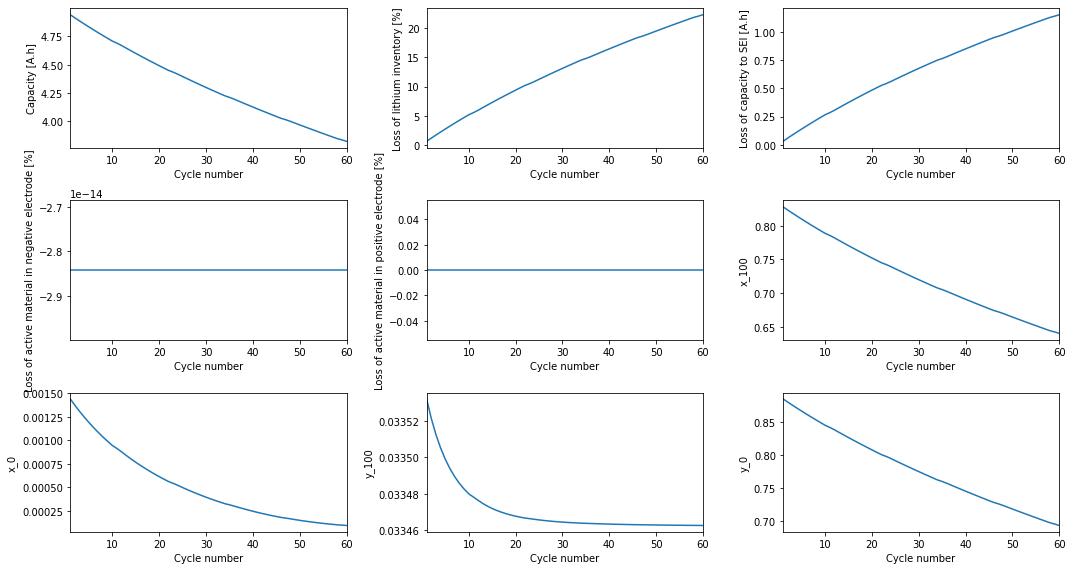

In [10]:
pybamm.plot_summary_variables(rpt_sol);

# References

The relevant papers for this notebook are:

In [11]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Ferran Brosa Planella and W. Dhammika Widanage. Systematic derivation of a Single Particle Model with Electrolyte and Side Reactions (SPMe+SR) for degradation of lithium-ion batteries. Submitted for publication, ():, 2022. doi:.
[3] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[4] Scott G. Marquis, Valentin Sulzer, Robert Timms, Colin P. Please, and S. Jon Chapman. An asymptotic derivation of a single particle model with electrolyte. Journal of The Electrochemical Society, 166(15):A3693–A3706, 2019. doi